# 📊 Pairs Trading Strategy using Clustering and Cointegration

## 📈 What is Pairs Trading?
Pairs Trading is a **market-neutral** strategy that profits from relative price movements between two historically correlated assets. The key steps are:

1. **Identify Cointegrated Pairs**: Assets that have historically moved together.
2. **Detect Divergence**: Look for moments when the price relationship temporarily breaks.
3. **Trade the Spread**: Short the outperforming asset and long the underperforming one.
4. **Revert to Mean**: Close positions when the spread returns to historical norms.

## 🎯 Goal of This Notebook
This notebook implements a full pipeline for building a pairs trading strategy:
- Load and clean stock price data
- Cluster stocks based on their Categories and Sectors 
- Reduce noise with PCA
- Cluster similar stocks using OPTICS
- Identify statistically valid pairs using cointegration
- Save reusable data with `pickle`


## **0. Initial Setup: Imports & Config**

This section imports essential libraries:

- `numpy`, `pandas`: Data handling
- `matplotlib`: Visualization
- `sklearn.cluster`: OPTICS for clustering stocks
- `sklearn.decomposition`: PCA for dimensionality reduction
- `statsmodels`: For statistical tests like cointegration
- `pickle`: Efficiently saves intermediate data objects

In [ ]:
import numpy as np
import random
import pandas as pd
import pickle
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.manifold import TSNE
from keras.layers import Dense, Flatten, LSTM, Dropout

from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

##  Data Processing with `DataProcessor`

We define a `DataProcessor` class to prepare the stock return data. It’s functions including: 

###  Data Preparation
- `split_data()`: Divides price data into training/test periods
- `remove_tickers_with_nan()`: Filters out stocks with too many missing values

###  Pair Discovery
- `get_candidate_pairs()`: Main method that finds tradable pairs within stock clusters
- `find_pairs()`: Evaluates all combinations in a cluster for valid pairs

###  Validation Checks
- `check_properties()`: Tests if two stocks are cointegrated (required for pairs trading)
- `check_for_stationarity()`: Uses ADF test to verify statistical properties

## Key Features
- Works with pre-clustered stocks for efficient searching
- Validates both training and testing period behavior
- Tracks reasons for pair rejections
- Optimized with subsampling for faster analysis

In [2]:
sys.path.append('/Users/zahraaghaei/Desktop/PairsTrading_master/notebooks/classes')
%load_ext autoreload
%aimport DataProcessor
%autoreload 1

# Create an instance of the DataProcessor
processor = DataProcessor.DataProcessor()

## 1. **Data Processing: Clean and split data**


### Loading and Splitting Price Data

This section loads historical price data, stores it in a serialized format for future use, and splits it into training and testing sets based on specified date ranges. 

In [3]:
df_prices = pd.read_excel('/Users/zahraaghaei/Desktop/PairsTrading_master/data/Prices.xlsx')
df_prices = df_prices.set_index('Date')
df_prices.to_pickle('/Users/zahraaghaei/Desktop/PairsTrading_master/Data/new_pickle/df_prices')

training_dates = ('01-01-2007', '31-12-2012')
testing_dates = ('01-01-2013', '31-12-2016')
train_val_split = '01-01-2010'
df_train, df_test = processor.split_data(df_prices, training_dates, testing_dates)

Total of 358 tickers
Total of 358 tickers after removing tickers with Nan values


## **2. Sector and Category Clustering**  
### Sector and Category Classification:
This section processes data to build mappings from each ticker to its respective **Segment**, **Sector**, and **Cluster Category**. This data is crucial for **filtering**, **grouping**, and **analyzing clustering results** later in the pipeline.

**Methodology**  
- Maps each ticker to its sector (e.g., `MMM → Industrials`)  
- Converts sector labels to numerical values (e.g., Technology → 7)  
- Enables quantitative analysis of sector-based relationships    

In [4]:
commodity = pd.read_excel('/Users/zahraaghaei/Desktop/PairsTrading_master/data/Tickers_and_Sectors.xlsx')
# remove duplicated
unique_commodity = commodity[~commodity.duplicated(subset=['Ticker'], keep='first')].sort_values(['Ticker'])
tickers = unique_commodity.Ticker.unique()
ticker_segment_dict = pd.Series(unique_commodity.Segment.values,index=unique_commodity.Ticker).to_dict()

Segment_mapper = (unique_commodity.groupby('Segment')['Sector'].unique()).to_dict()
Segment_mapper = {k: v[0] if len(v) > 0 else None for k, v in Segment_mapper.items()}

Clustering_mapper = {'Communication Services':0,'Industrials':1,'Basic Materials':2, 'Consumer Cyclical':3, 'Financial':4,
                    'Consumer Defensive':5, 'Healthcare':6, 'Technology':7, 'Energy':8, 'Real Estate':9, 'Utilities':10}

In [5]:
df_category = pd.DataFrame(data =df_train.columns, columns=['Ticker'])
df_category['Segment'] = df_category['Ticker'].apply(lambda row: ticker_segment_dict[row])
df_category['Category'] = df_category['Segment'].apply(lambda row: Segment_mapper[row])
df_category['Category_cluster'] = df_category['Category'].apply(lambda row: Clustering_mapper[row])
df_category = df_category.set_index('Ticker')

In [6]:
df_category

Segment                Category  \
Ticker                                                            
MMM      Specialty Industrial Machinery             Industrials   
ABT                     Medical Devices              Healthcare   
ACN     Information Technology Services              Technology   
ATVI     Electronic Gaming & Multimedia  Communication Services   
ADBE          Software - Infrastructure              Technology   
...                                 ...                     ...   
XRX     Information Technology Services              Technology   
XLNX                     Semiconductors              Technology   
YUM                         Restaurants       Consumer Cyclical   
ZBH                     Medical Devices              Healthcare   
ZION                   Banks - Regional               Financial   

        Category_cluster  
Ticker                    
MMM                    1  
ABT                    6  
ACN                    7  
ATVI                   0  
ADBE                   7  
...                  ...  
XRX                    7  
XLNX                   7  
YUM                    3  
ZBH                    6  
ZION                   4  

[358 rows x 3 columns]

### Saving Ticker Data: Category and Segment Dictionaries

We create and store dictionaries that map stock tickers to their **industry categories** and **segments**. 

In [7]:
ticker_category_dict = pd.Series(df_category.Category.values,index=df_category.index).to_dict()

with open('/Users/zahraaghaei/Desktop/PairsTrading_master/data/new_pickle/ticker_segment_dict', 'wb') as handle:
    pickle.dump(ticker_segment_dict, handle)

with open('/Users/zahraaghaei/Desktop/PairsTrading_master/data/new_pickle/ticker_category_dict', 'wb') as handle:
    pickle.dump(ticker_category_dict, handle)

In [8]:
with open("/Users/zahraaghaei/Desktop/PairsTrading_master/data/new_pickle/ticker_segment_dict", 'rb') as handle:
    ticker_segment_dict = pickle.load(handle)

### Dataset Review & Summary Statistics  

This section reviews the structure of the training and testing datasets, as well as the available category information used for potential pair combinations.


In [9]:
#Review 
print('Trading days: ', len(np.unique(df_train.index.date))+len(np.unique(df_test.index.date)))
print('Begin: ', df_train.index.date[0])
print('End: ', df_test.index.date[-1])
print('{} Samples including :: train: {} - test: {} - validation: {}'.format(
    len(df_train) + len(df_test), 
    len(df_train),
    len(df_test),
    len(df_train[train_val_split:])
))
print(df_category['Category'].value_counts())
combinations = 0
for i,count in enumerate(df_category['Category'].value_counts().values):
    combinations += count*(count-1)
print('Possible number of pairs: ', combinations)

Trading days:  2518
Begin:  2007-01-03
End:  2016-12-30
2518 Samples including :: train: 1510 - test: 1008 - validation: 754
Category
Industrials               52
Consumer Cyclical         51
Financial                 47
Healthcare                45
Technology                39
Consumer Defensive        29
Utilities                 25
Energy                    23
Real Estate               20
Communication Services    14
Basic Materials           13
Name: count, dtype: int64
Possible number of pairs:  13462


## **3. Pairs Identification** 

### Selecting Statistically Significant Pairs for Trading

In this step, we generate candidate pairs using a **cointegration-based filtering method**. The aim is to identify pairs of assets that exhibit a statistically strong mean-reverting relationship — a key requirement for successful **pairs trading**.

**Methodology**  
- Computes possible intra-sector pairs (n*(n-1)/2 per sector) 
- Engle-Granger test with p-value threshold (0.01)  
- Validates long-term equilibrium relationships  
**Output**: 297 statistically significant pairs identified.


In [10]:
pairs_category, unique_tickers = processor.get_candidate_pairs(df_category['Category_cluster'], df_train, df_test, 
                                                               p_value_threshold=0.01, subsample=2500)

Cluster 11/11Found 297 pairs
The pairs contain 224 unique tickers
Pairs Selection failed stage:  {'cointegration': 6434, 'None': 297}


### Category Distribution  
This section inspects the selected pairs based on their **industry category**.

In [11]:
categories_found =pd.Series([ticker_category_dict[pair[0]] for pair in pairs_category])
categories_found.value_counts()

Industrials               74
Consumer Cyclical         52
Healthcare                45
Financial                 44
Consumer Defensive        28
Technology                21
Utilities                 18
Basic Materials            5
Energy                     5
Communication Services     3
Real Estate                2
Name: count, dtype: int64

### Sector Distribution 
This section inspects the selected pairs based on their **segment** to evaluate how often pairs are formed across different business domains.

In [12]:
count_different_category = 0
for pair in pairs_category:
    print('------------------------------------------------')
    print('Leg 1: {}. Segment: {}. Category: {}'.format(pair[0], df_category.loc[pair[0]]['Segment'] ,
                                                        df_category.loc[pair[0]]['Category']))
    print('Leg 2: {}. Segment: {}. Category: {}'.format(pair[1], df_category.loc[pair[1]]['Segment'],
                                                        df_category.loc[pair[1]]['Category']))
    if df_category.loc[pair[0]]['Category'] != df_category.loc[pair[1]]['Category']:
        count_different_category += 1
print('There are {} pairs from different categories'.format(count_different_category))

------------------------------------------------
Leg 1: T. Segment: Telecom Services. Category: Communication Services
Leg 2: FOXA. Segment: Broadcasting. Category: Communication Services
------------------------------------------------
Leg 1: CTL. Segment: Telecom Services. Category: Communication Services
Leg 2: IPG. Segment: Advertising Agencies. Category: Communication Services
------------------------------------------------
Leg 1: IPG. Segment: Advertising Agencies. Category: Communication Services
Leg 2: OMC. Segment: Advertising Agencies. Category: Communication Services
------------------------------------------------
Leg 1: MMM. Segment: Specialty Industrial Machinery. Category: Industrials
Leg 2: SWK. Segment: Tools & Accessories. Category: Industrials
------------------------------------------------
Leg 1: MMM. Segment: Specialty Industrial Machinery. Category: Industrials
Leg 2: WM. Segment: Waste Management. Category: Industrials
------------------------------------------

### Saving Selected Pairs by Category

After selecting valid trading pairs (stored in `pairs_category`), we persist them to disk for future reuse.

In [13]:
with open('/Users/zahraaghaei/Desktop/PairsTrading_master/data/new_pickle/pairs_category', 'wb') as f:
    pickle.dump(pairs_category, f)

In [14]:
pair_path = "/Users/zahraaghaei/Desktop/PairsTrading_master/data/new_pickle/pairs_category"
with open(pair_path, 'rb') as handle:
    pairs_category = pickle.load(handle)

## **2. Clustering using Unsupervised Learning Techniques**
## Group stocks into structurally similar clusters  

### Dimensionality Reduction: 
To efficiently cluster high-dimensional financial time series data, we first reduce dimensionality using **Principal Component Analysis (PCA)** and then apply the **OPTICS** clustering algorithm.

**PCA Implementation**:  
- Condenses returns data into 5 principal components  
- Explains >12% variance in first component
  
### OPTICS Clustering:
OPTICS Clusters the reduced-dimensional data using the OPTICS algorithm (Ordering Points To Identify the Clustering Structure), which is well-suited for identifying clusters of varying density in noisy datasets.

**OPTICS Implementation**:  
- Handles varying density clusters  
- Automatically determines cluster hierarchy  
**Result**: 24 natural groupings of assets with similar behaviors.

In [49]:
def apply_PCA(n_components, df, svd_solver='auto', random_state=0):
    """
    This function applies Principal Component Analysis to the df given as
    parameter

    :param n_components: number of principal components
    :param df: dataframe containing time series for analysis
    :param svd_solver: solver for PCA: see PCA documentation
    :return: reduced normalized and transposed df
    """

    if not isinstance(n_components, str):
        if n_components > df.shape[1]:
            print("ERROR: number of components larger than samples...")
            exit()

    pca = PCA(n_components=n_components, svd_solver=svd_solver, random_state=random_state)
    pca.fit(df)
    explained_variance = pca.explained_variance_

    # standardize
    X = preprocessing.StandardScaler().fit_transform(pca.components_.T)

    return X, explained_variance

def apply_OPTICS(X, df_returns, min_samples, max_eps=2, xi=0.05, cluster_method='xi'):
    """

    :param X:
    :param df_returns:
    :param min_samples:
    :param max_eps:
    :param xi:
    :param eps:
    :return:
    """
    clf = OPTICS(min_samples=min_samples, max_eps=max_eps, xi=xi, metric='euclidean', cluster_method=cluster_method)

    clf.fit(X)
    labels = clf.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    print("Clusters discovered with OPTICS algorithm: %d" % n_clusters_)

    clustered_series_all = pd.Series(index=df_returns.columns, data=labels.flatten())
    clustered_series = clustered_series_all[clustered_series_all != -1]

    counts = clustered_series.value_counts()
    print("Pairs to evaluate with OPTICS algorithm: %d" % (counts * (counts - 1) / 2).sum())

    return clustered_series_all, clustered_series, counts, clf


[0.121521   0.01217729 0.00664894 0.00462571 0.00386882]


### Applying PCA and OPTICS to Price Returns

In this section, we prepare the returns data and use PCA and OPTICS to discover structurally similar clusters. 

In [113]:
df_returns_train = df_train.pct_change()
df_returns_train = df_returns_train.iloc[1:]

N_PRIN_COMPONENTS = 5
X, explained_variance = apply_PCA(N_PRIN_COMPONENTS, df_returns_train, random_state=0)
print(explained_variance)

clustered_series_all_OPTICS, clustered_series_OPTICS, counts_OPTICS, clf_OPTICS = apply_OPTICS(X, 
                                                                                               df_returns_train, 
                                                                                               min_samples=3, 
                                                                                               cluster_method='xi')

[0.121521   0.01217729 0.00664894 0.00462571 0.00386882]
Clusters discovered with OPTICS algorithm: 24
Pairs to evaluate with OPTICS algorithm: 366


### Cluster Visualization
To better understand the distribution of tickers across clusters, we define a utility function that generates a **horizontal bar chart** of cluster sizes. 
- X-axis: Cluster ID  
- Y-axis: Member of tickers

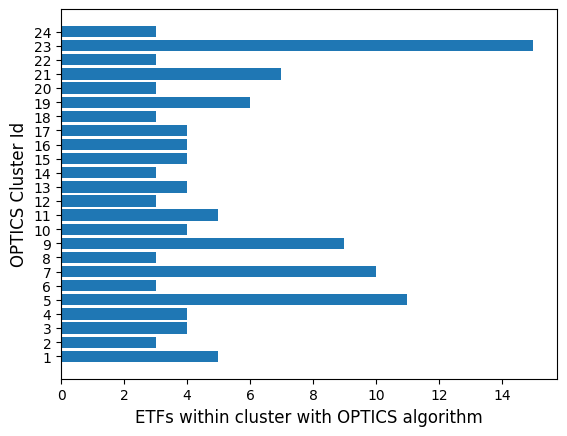

In [51]:
def cluster_size(counts, stri):
    plt.figure()
    plt.barh(counts.index+1, counts.values)
    #plt.title('Cluster Member Counts')
    plt.yticks(np.arange(1, len(counts)+1, 1))
    plt.xlabel('ETFs within cluster with %s algorithm' % stri, size=12)
    plt.ylabel('%s Cluster Id' % stri, size=12);
    
#cluster_size(counts_DBSCAN, 'DBSCAN')
cluster_size(counts_OPTICS, 'OPTICS')

### Cluster Composition 
This section reviews the composition of each cluster produced by the **OPTICS** clustering algorithm. It prints the tickers and their associated **segments** for every cluster.

In [52]:
for label_n in range(len(counts_OPTICS)):
    elements_cluster_n = list(clustered_series_OPTICS[clustered_series_OPTICS == label_n].index)
    etfs_cluster_n = unique_commodity[unique_commodity['Ticker'].isin(elements_cluster_n)]
    print('\nOPTICS Cluster {}:\n{}'.format(label_n, etfs_cluster_n[['Ticker', 'Segment']]))


OPTICS Cluster 0:
    Ticker                              Segment
135   FISV      Information Technology Services
0      MMM       Specialty Industrial Machinery
254   PDCO                 Medical Distribution
88     STZ  Beverages - Wineries & Distilleries
320    TSN                        Farm Products

OPTICS Cluster 1:
    Ticker                        Segment
39     AVY  Business Equipment & Supplies
74    CSCO        Communication Equipment
181    JCI     Engineering & Construction

OPTICS Cluster 2:
    Ticker                         Segment
115    EMR  Specialty Industrial Machinery
253     PH  Specialty Industrial Machinery
287    ROP  Specialty Industrial Machinery
333   VRSN       Software - Infrastructure

OPTICS Cluster 3:
    Ticker                 Segment
49      BA     Aerospace & Defense
40     BLL  Packaging & Containers
96     DHR  Diagnostics & Research
178    IRM        REIT - Specialty

OPTICS Cluster 4:
    Ticker                         Segment
23     ABC      

### Visualizing Clusters with t-SNE

To gain insights into the structure and separation of clusters discovered by the OPTICS algorithm, we use **t-distributed Stochastic Neighbor Embedding (t-SNE)** to project high-dimensional PCA data into 2D space.

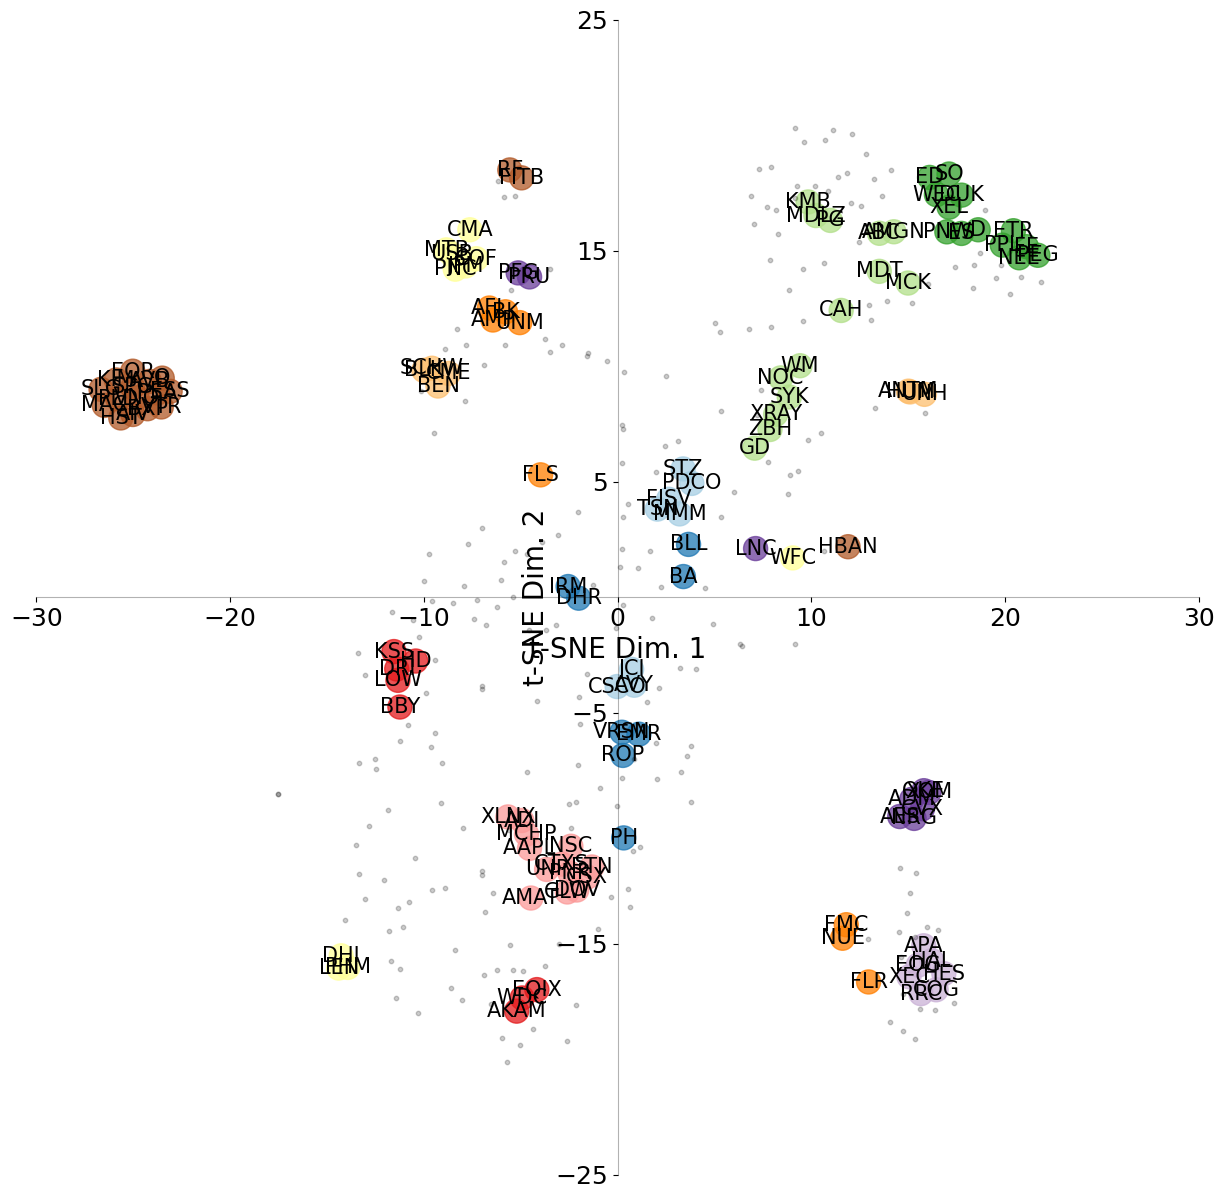

In [87]:
def plot_TSNE(X, clf, clustered_series_all, string):
    """
    This function uses t-SNE to visualize clusters in 2D with proper label matching.
    """
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import numpy as np
    import pandas as pd

    # Perform t-SNE dimensionality reduction
    X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(X)
    
    # Create a DataFrame to ensure consistent ordering
    tsne_df = pd.DataFrame({
        'x': X_tsne[:, 0],
        'y': X_tsne[:, 1],
        'ticker': clustered_series_all.index,
        'label': clf.labels_
    })
    
    # Set up visualization
    fig = plt.figure(1, facecolor='white', figsize=(15, 15), frameon=True, edgecolor='black')
    plt.clf()
    
    # Configure axes
    ax = fig.add_subplot(1, 1, 1, alpha=0.9)
    ax.spines['left'].set_position('center')
    ax.spines['left'].set_alpha(0.3)
    ax.spines['bottom'].set_position('center')
    ax.spines['bottom'].set_alpha(0.3)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.tick_params(which='major', labelsize=18)

    # Split into clustered and unclustered points
    clustered = tsne_df[tsne_df['label'] != -1]
    unclustered = tsne_df[tsne_df['label'] == -1]
    
    # Plot clustered points with colors
    scatter = plt.scatter(
        clustered['x'],
        clustered['y'],
        s=300,
        alpha=0.75,
        c=clustered['label'],
        cmap=cm.Paired
    )
    
    # Add labels for clustered points with proper alignment
    for _, row in clustered.iterrows():
        plt.annotate(
            row['ticker'],
            (row['x'], row['y']),
            size=15,
            ha='center',
            va='center'
        )

    # Plot unclustered points (outliers)
    plt.scatter(
        unclustered['x'],
        unclustered['y'],
        s=10,
        alpha=0.20,
        c='black'
    )

    # Configure plot labels and ticks
    plt.xlabel('t-SNE Dim. 1', position=(0.92, 0), size=20)
    plt.ylabel('t-SNE Dim. 2', position=(0, 0.92), size=20)
    ax.set_xticks(range(-30, 40, 10))
    ax.set_yticks(range(-25, 30, 10))
    
    # Fixed legend code
    # unique_labels = np.unique(clustered['label'])
    # legend_labels = [f'Cluster {i}' for i in unique_labels]
    # handles, _ = scatter.legend_elements()
    # plt.legend(
    #     handles=handles[:len(unique_labels)],
    #     labels=legend_labels,
    #     title='Clusters',
    #     fontsize=12,
    #     title_fontsize=14,
    #     loc='upper right'
    # )
    
    # Save and show plot
    #plt.savefig(f'TSNE_plot_{string}.png', bbox_inches='tight', pad_inches=0.1, dpi=300)
    plt.show()

#plot_TSNE(X,clf_DBSCAN, clustered_series_all_DBSCAN, 'DBSCAN')
plot_TSNE(X,clf_OPTICS, clustered_series_all_OPTICS, 'OPTICS')

### Time Series Visualization of OPTICS Clusters

To better understand the internal behavior of each cluster formed by the OPTICS algorithm, we visualize the **log-transformed, mean-centered time series** of each asset within every cluster.


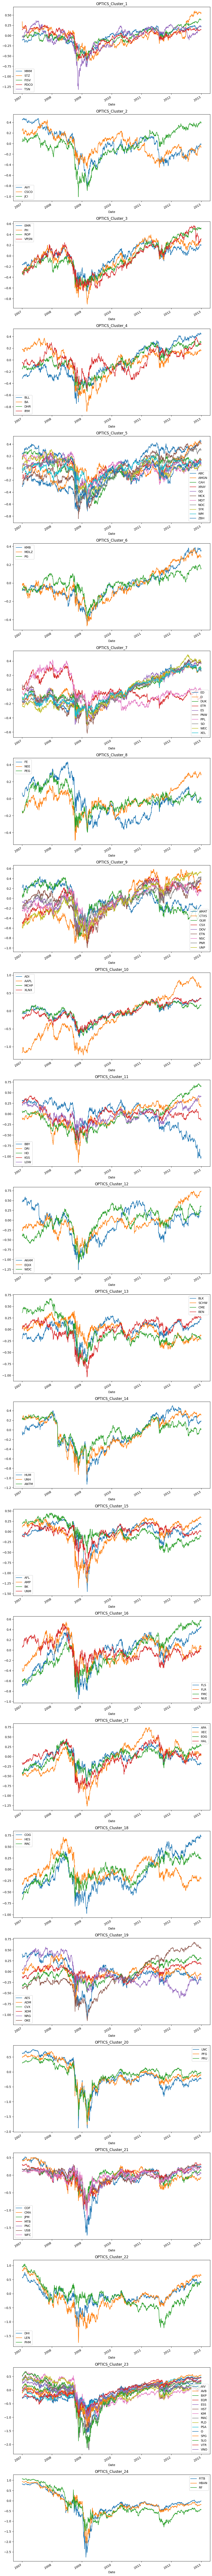

In [94]:
fig, axes = plt.subplots(len(counts_OPTICS), 1, figsize=(10, 5*len(counts_OPTICS)))

for clust, ax in enumerate(axes):
    symbols = list(clustered_series_OPTICS[clustered_series_OPTICS==clust].index)
    means = np.log(df_train[symbols].mean())
    series = np.log(df_train[symbols]).sub(means)
    
    series.plot(ax=ax)
    ax.set_title('OPTICS_Cluster_{}'.format(str(clust+1)))

plt.tight_layout()
#plt.savefig('all_OPTICS_clusters.png', bbox_inches='tight', pad_inches=0.1)

## **3. Pairs Identification** 

### Generating Unsupervised Pairs Using OPTICS Clustering

In this section, we apply the `get_candidate_pairs()` function using **OPTICS clustering labels** instead of predefined category clusters. This enables a fully **unsupervised learning approach** to pairs generation, where the data itself determines meaningful groupings of ETFs.

**Methodology**  
- Computes possible intra-sector pairs (n*(n-1)/2 per sector) 
- Engle-Granger test with p-value threshold (0.01)  
- Validates long-term equilibrium relationships  
**Output**: 22 statistically significant pairs identified.


In [95]:
pairs_OPTICS_unsupervised, unique_tickers = processor.get_candidate_pairs(clustered_series_OPTICS, df_train, df_test, 
                                                               p_value_threshold=0.01, subsample=2500)

Cluster 24/24Found 22 pairs
The pairs contain 31 unique tickers
Pairs Selection failed stage:  {'cointegration': 344, 'None': 22}


### Time Series Visualization of **spread**

The function `plot_all_spreads` is designed to efficiently plot the "spread" time series for each identified pair.


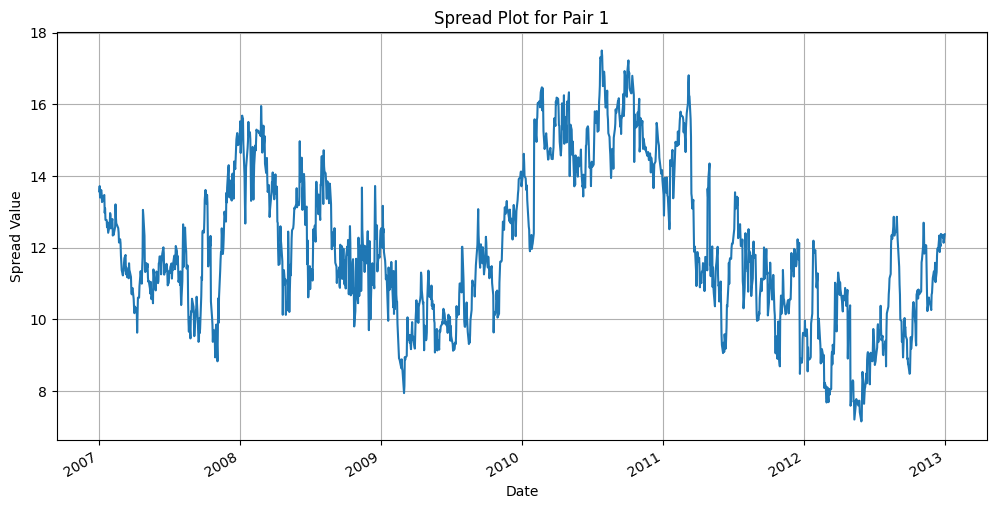

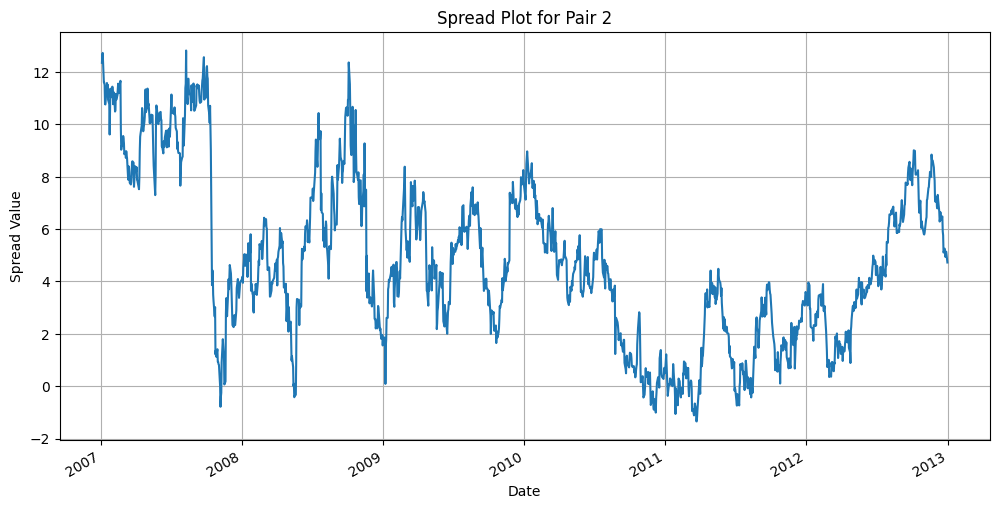

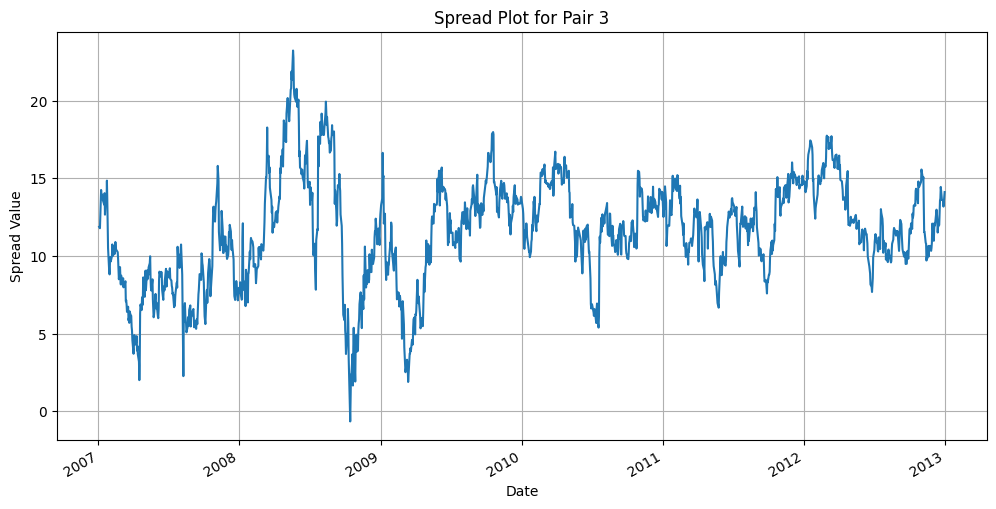

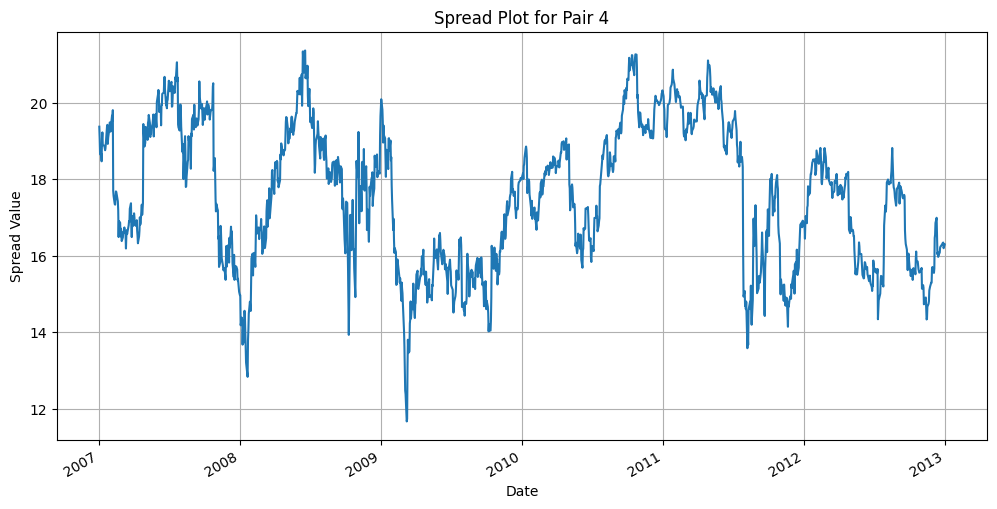

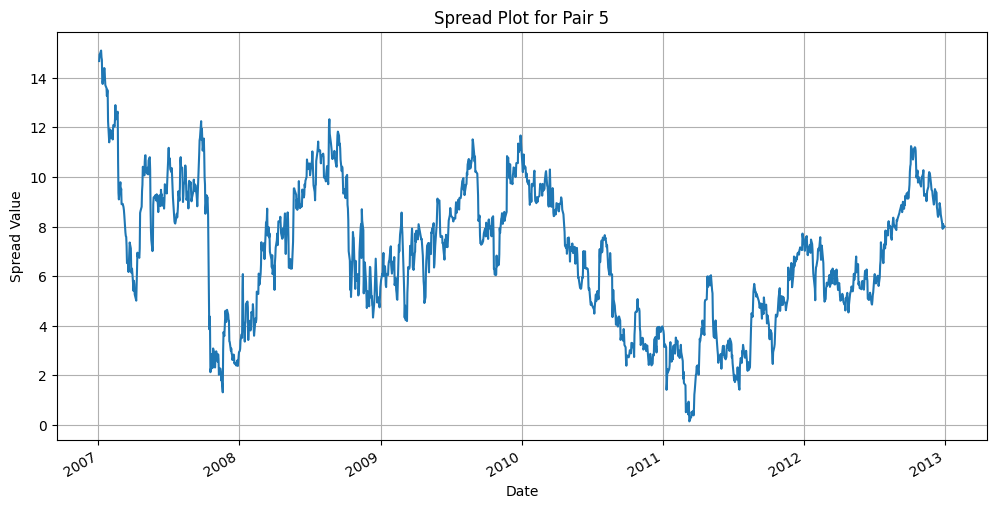

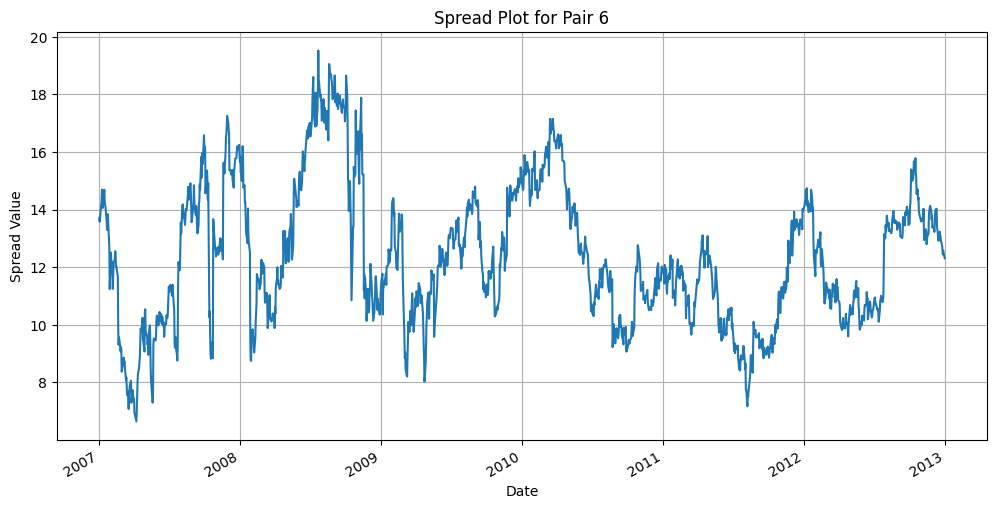

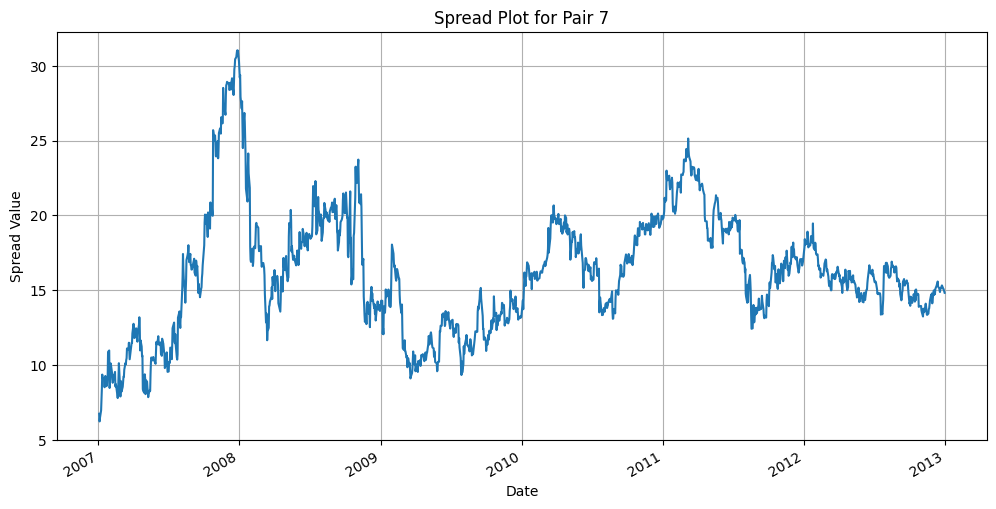

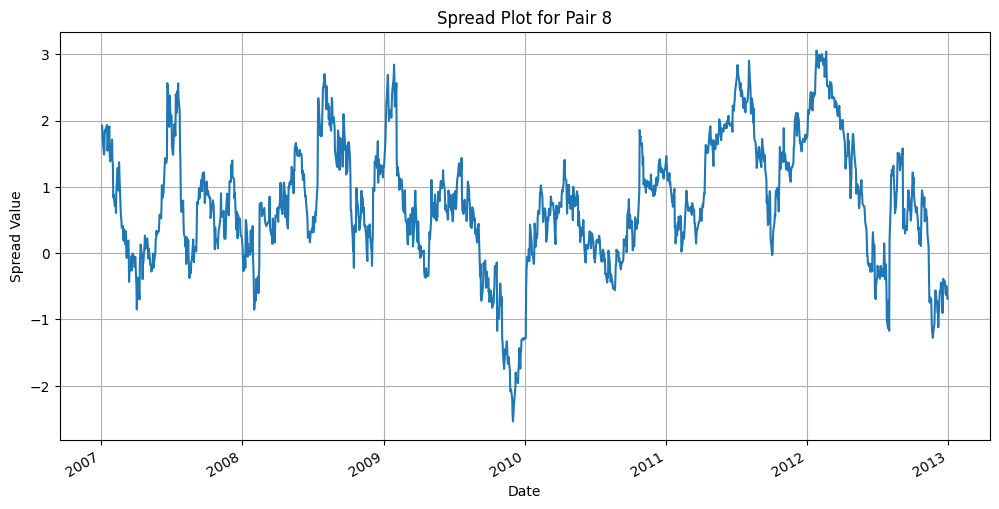

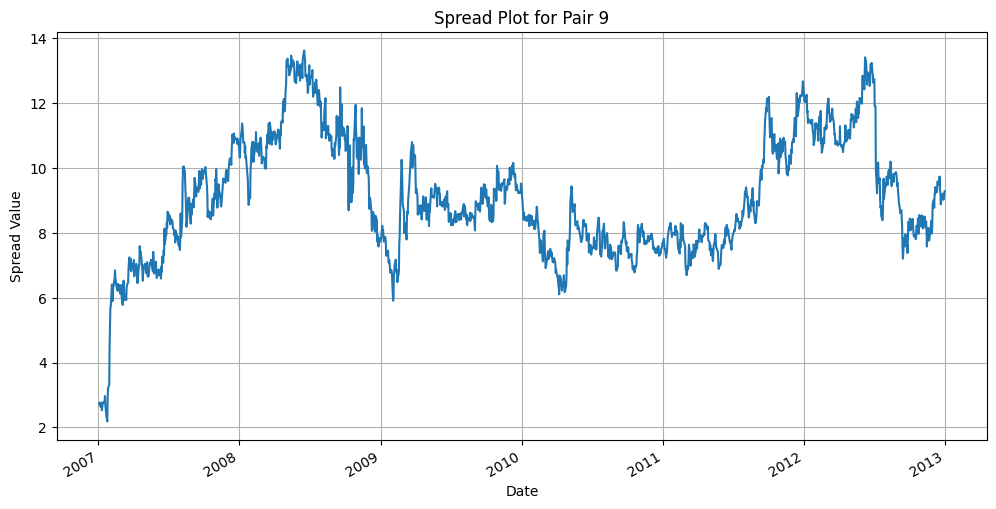

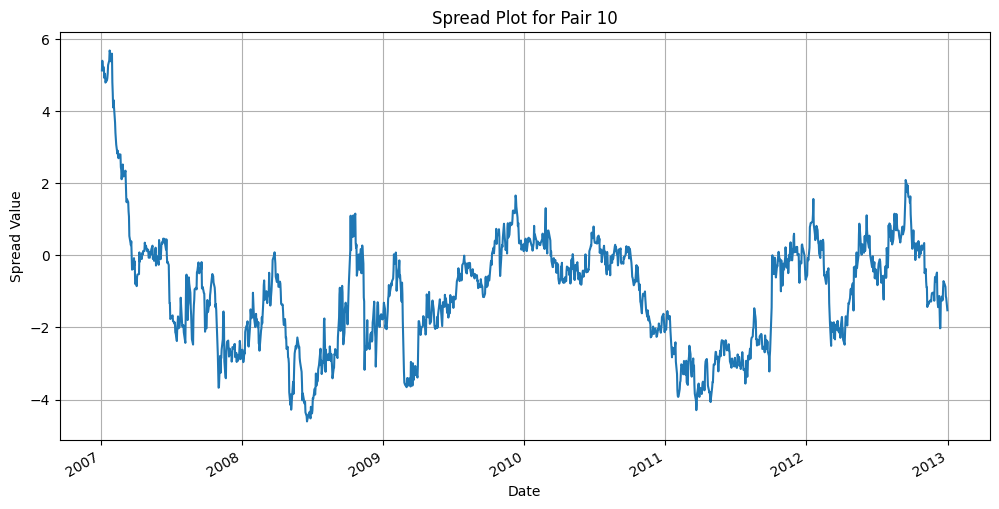

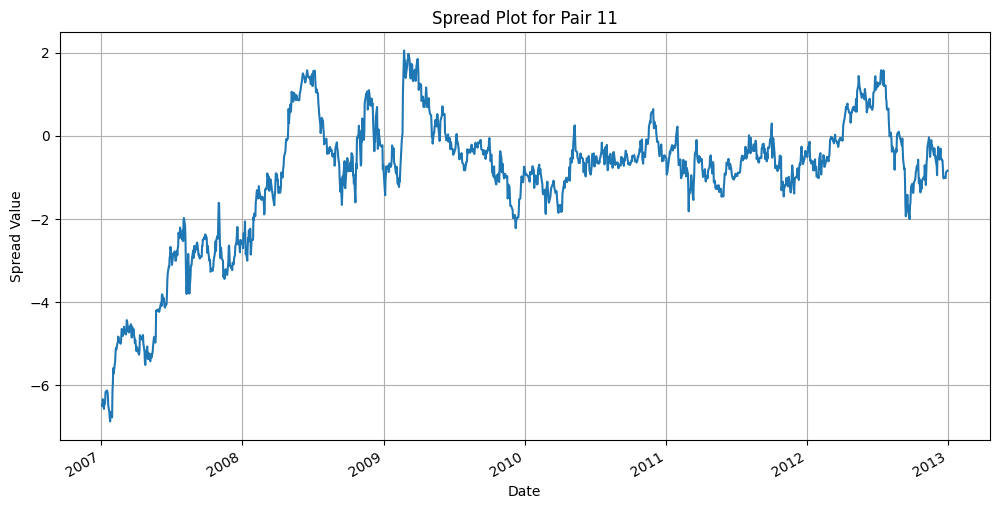

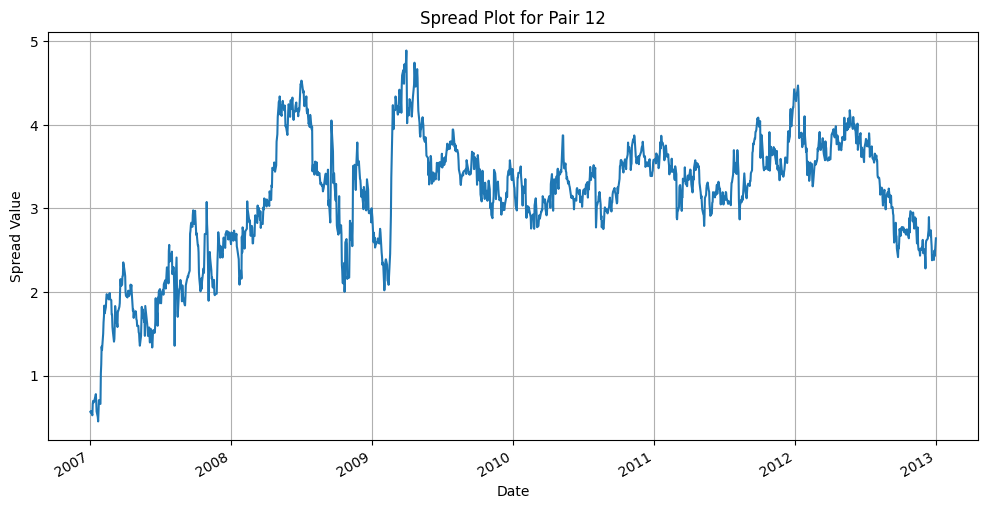

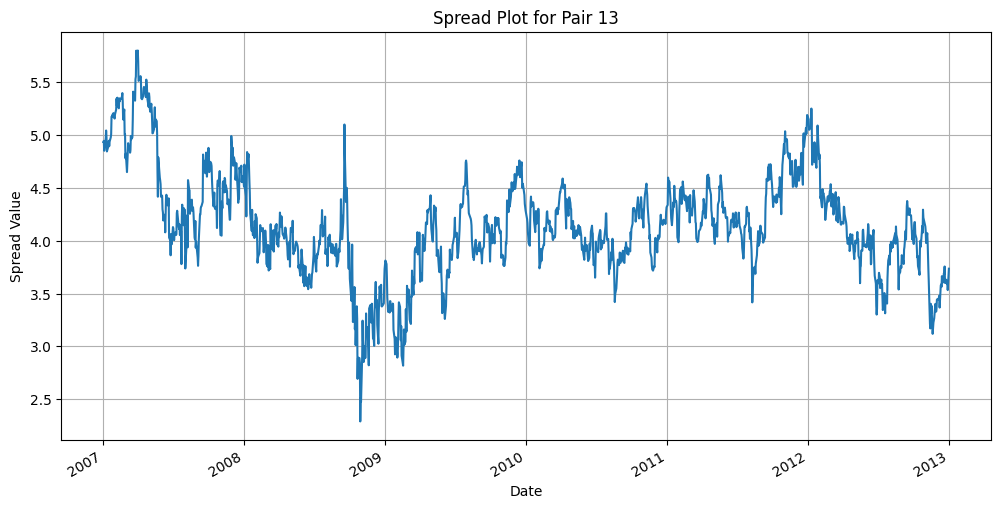

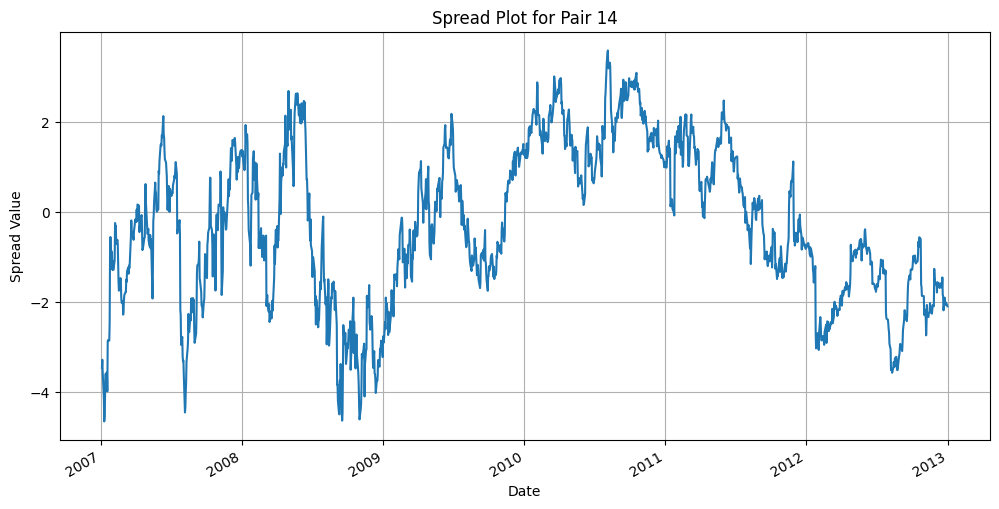

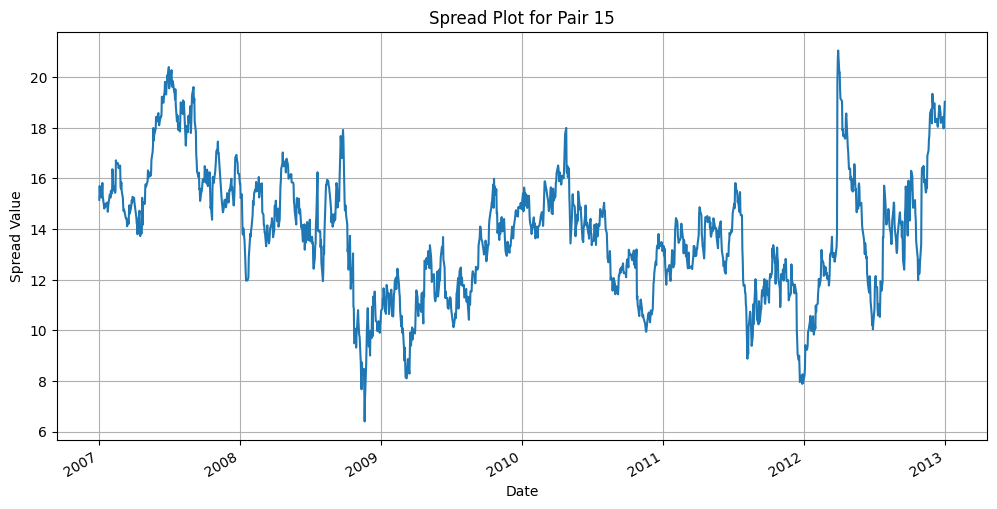

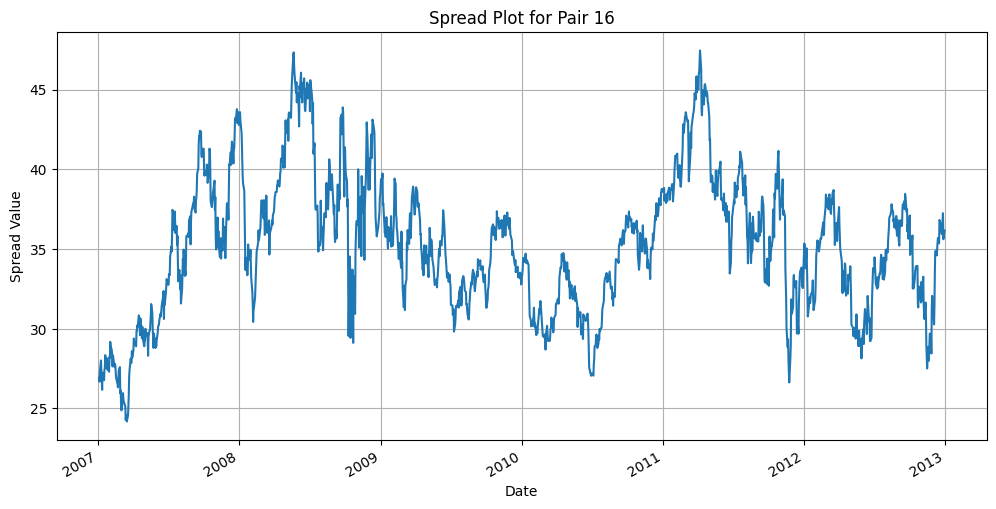

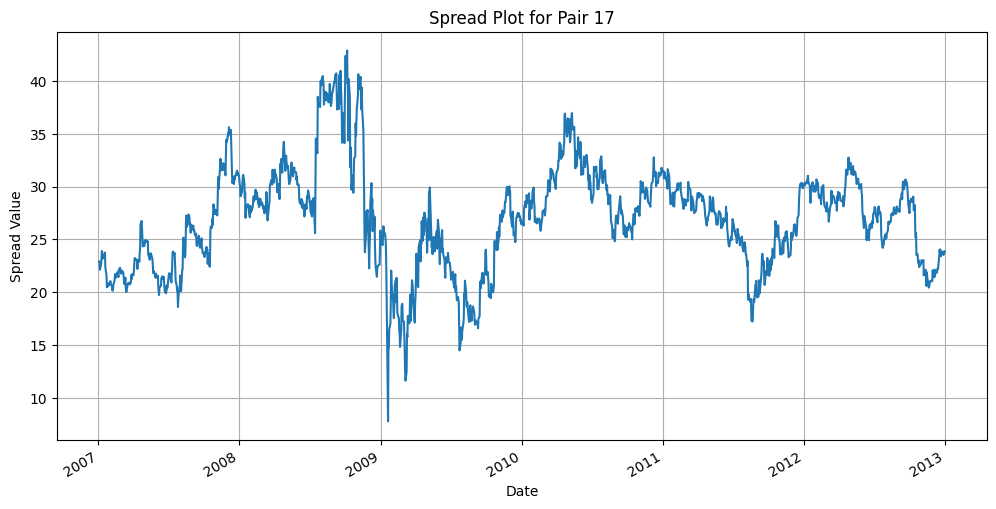

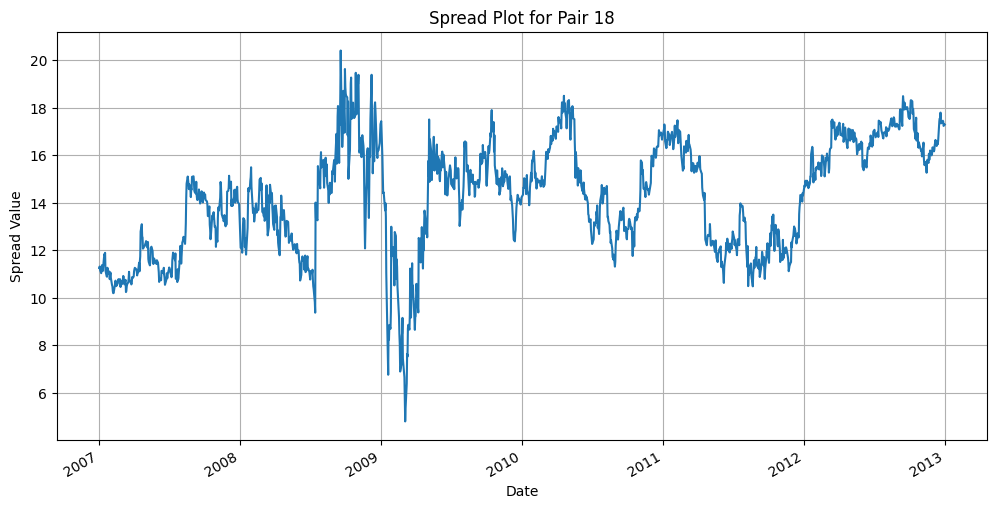

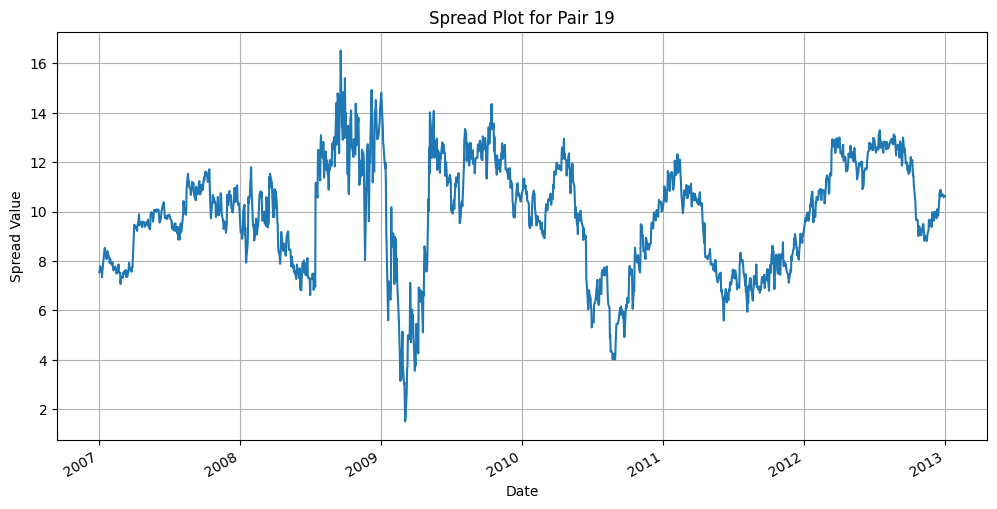

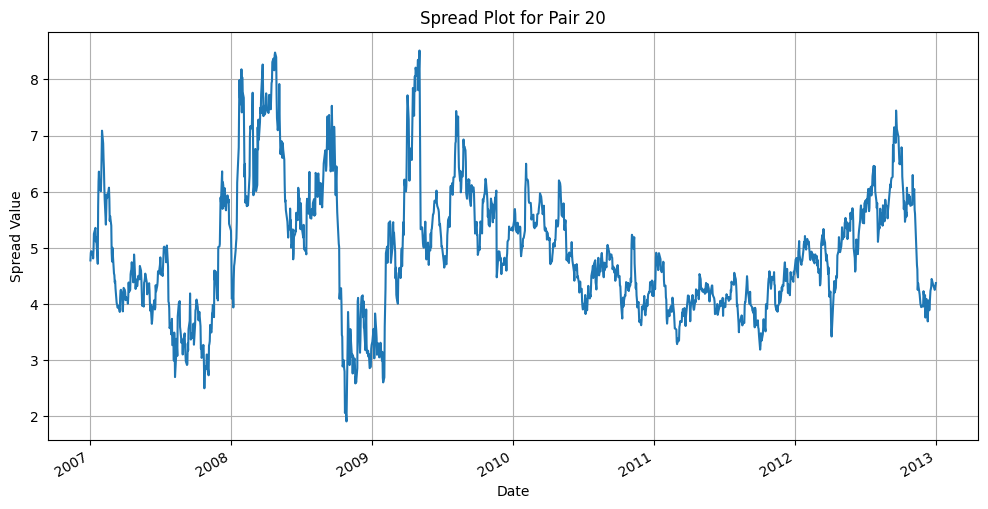

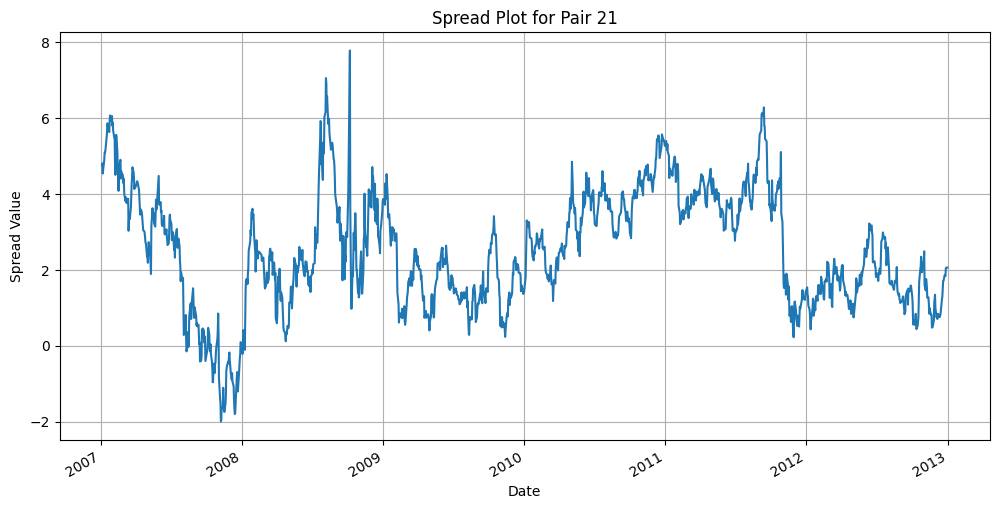

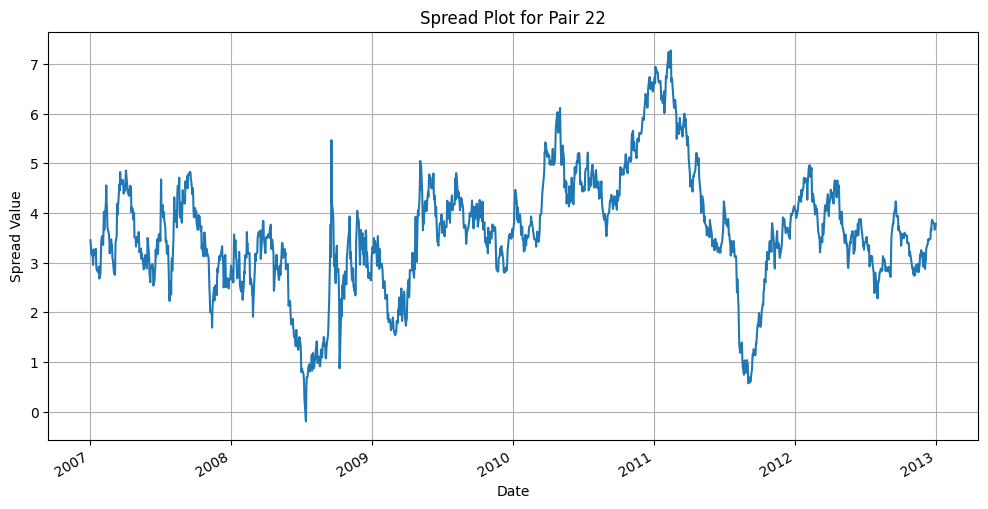

In [106]:
mpl.rcParams['figure.max_open_warning'] = 0
def plot_all_spreads(pairs, save_path=None):
    """Efficiently plot all spreads with memory management"""
    for i, pair in enumerate(pairs):
        fig = plt.figure(figsize=(12, 6))
        pair[2]['spread'].plot()
        plt.title(f'Spread Plot for Pair {i+1}')
        plt.xlabel('Date')
        plt.ylabel('Spread Value')
        plt.grid(True)
        
        if save_path:
            plt.savefig(f'{save_path}/pair_{i+1}.png', dpi=300, bbox_inches='tight')

plot_all_spreads(pairs_OPTICS_unsupervised, save_path=None)

### Sector Distribution 
This section inspects the identified pairs based on their **segment** to evaluate how often pairs are formed across different business domains.

In [102]:
count_different_category = 0
for pair in pairs_OPTICS_unsupervised:
    print('------------------------------------------------')
    print('Leg 1: {}. Segment: {}. Category: {}'.format(pair[0], df_category.loc[pair[0]]['Segment'] ,
                                                        df_category.loc[pair[0]]['Category']))
    print('Leg 2: {}. Segment: {}. Category: {}'.format(pair[1], df_category.loc[pair[1]]['Segment'],
                                                        df_category.loc[pair[1]]['Category']))
    if df_category.loc[pair[0]]['Category'] != df_category.loc[pair[1]]['Category']:
        count_different_category += 1
print('There are {} pairs from different categories'.format(count_different_category))

------------------------------------------------
Leg 1: EMR. Segment: Specialty Industrial Machinery. Category: Industrials
Leg 2: PH. Segment: Specialty Industrial Machinery. Category: Industrials
------------------------------------------------
Leg 1: GD. Segment: Aerospace & Defense. Category: Industrials
Leg 2: MDT. Segment: Medical Devices. Category: Healthcare
------------------------------------------------
Leg 1: GD. Segment: Aerospace & Defense. Category: Industrials
Leg 2: SYK. Segment: Medical Devices. Category: Healthcare
------------------------------------------------
Leg 1: MCK. Segment: Medical Distribution. Category: Healthcare
Leg 2: WM. Segment: Waste Management. Category: Industrials
------------------------------------------------
Leg 1: MDT. Segment: Medical Devices. Category: Healthcare
Leg 2: SYK. Segment: Medical Devices. Category: Healthcare
------------------------------------------------
Leg 1: MDT. Segment: Medical Devices. Category: Healthcare
Leg 2: ZBH. 

### Saving Identified Pairs Created by OPTICS Clustering 

After selecting valid trading pairs (stored in `pairs_OPTICS_unsupervised`), we persist them to disk for future reuse.

In [103]:
with open('/Users/zahraaghaei/Desktop/PairsTrading_master/data/new_pickle/pairs_OPTICS_unsupervised', 'wb') as f:
    pickle.dump(pairs_OPTICS_unsupervised, f)